In [48]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import datetime as dt
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from factor_analyzer import FactorAnalyzer, Rotator
from sklearn.decomposition import FactorAnalysis
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Base data directory
DATA_DIR = Path("data")

In [67]:
county_dtypes = {
    "geo_id": str,
    "state": str,
    "county_name": str,
    "urban_classification": str
}

county_df = pd.read_csv(DATA_DIR / "county_weather_acs_training.csv", dtype=county_dtypes)

# Identify non-weather and raw change columns
non_weather_cols = [col for col in county_df.columns if not any(
    substr in col for substr in [
        "avg_temp", "heat_days", "max_temp", "total_precip",
        "num_events", "total_deaths", "total_injuries",
        "total_property_damage", "total_crop_damage", "_change"
    ])
]

county_df = county_df[non_weather_cols].copy()

pop_columns = [
    "white_pop",
    "black_pop",
    "hispanic_pop",
    "asian_pop",
    "bachelors_degree_or_higher_25_64",
    "less_than_high_school_graduate",
    "some_college_and_associates_degree",
    "different_house_year_ago_same_city",
    "different_house_year_ago_different_city"
]

# Adjust population columns to percentage of total population and rename
for col in pop_columns:
    county_df[col] = county_df[col] / county_df["total_pop"]
    new_col_name = col + "_pct"
    county_df.rename(columns={col: new_col_name}, inplace=True)

county_df = county_df.copy()

# Ensure consistent percentage scale``
for i in county_df.columns:
    if i.endswith("_pct_yoy") or i.__contains__("percent") and county_df[i].max() > 1:
        county_df[i] = county_df[i] / 100 
        
county_df.drop(columns=[
    "reporting_stations", \
    "state_fips", 
    "county_geometry",
    "county_fips", 
    "County_Name",
    "Population_2020", 
    "has_acs", 
    "median_income", 
    "total_pop", 
    "poverty", 
    "gini_index",
    "median_rent",
    "total_pop_roll3",
    "poverty_roll3",
    "percent_income_spent_on_rent",
    "rent_over_50_percent"], inplace=True)

for col in county_df.columns:
    if county_df[col].isnull().sum() > 0:
        # Fill within geo_id group
        county_df[col] = county_df.groupby("geo_id")[col].transform(
            lambda grp: grp.fillna(grp.mean())
        )

        # Fill remaining NaNs with column-wide mean (avoiding chained assignment)
        county_df[col] = county_df[col].fillna(county_df[col].mean())

    

# print(county_df.info())
print(county_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 27 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   geo_id                                       16860 non-null  object 
 1   county_name                                  16860 non-null  object 
 2   year                                         16860 non-null  int64  
 3   median_age                                   16860 non-null  float64
 4   white_pop_pct                                16860 non-null  float64
 5   black_pop_pct                                16860 non-null  float64
 6   hispanic_pop_pct                             16860 non-null  float64
 7   asian_pop_pct                                16860 non-null  float64
 8   bachelors_degree_or_higher_25_64_pct         16860 non-null  float64
 9   less_than_high_school_graduate_pct           16860 non-null  float64
 10

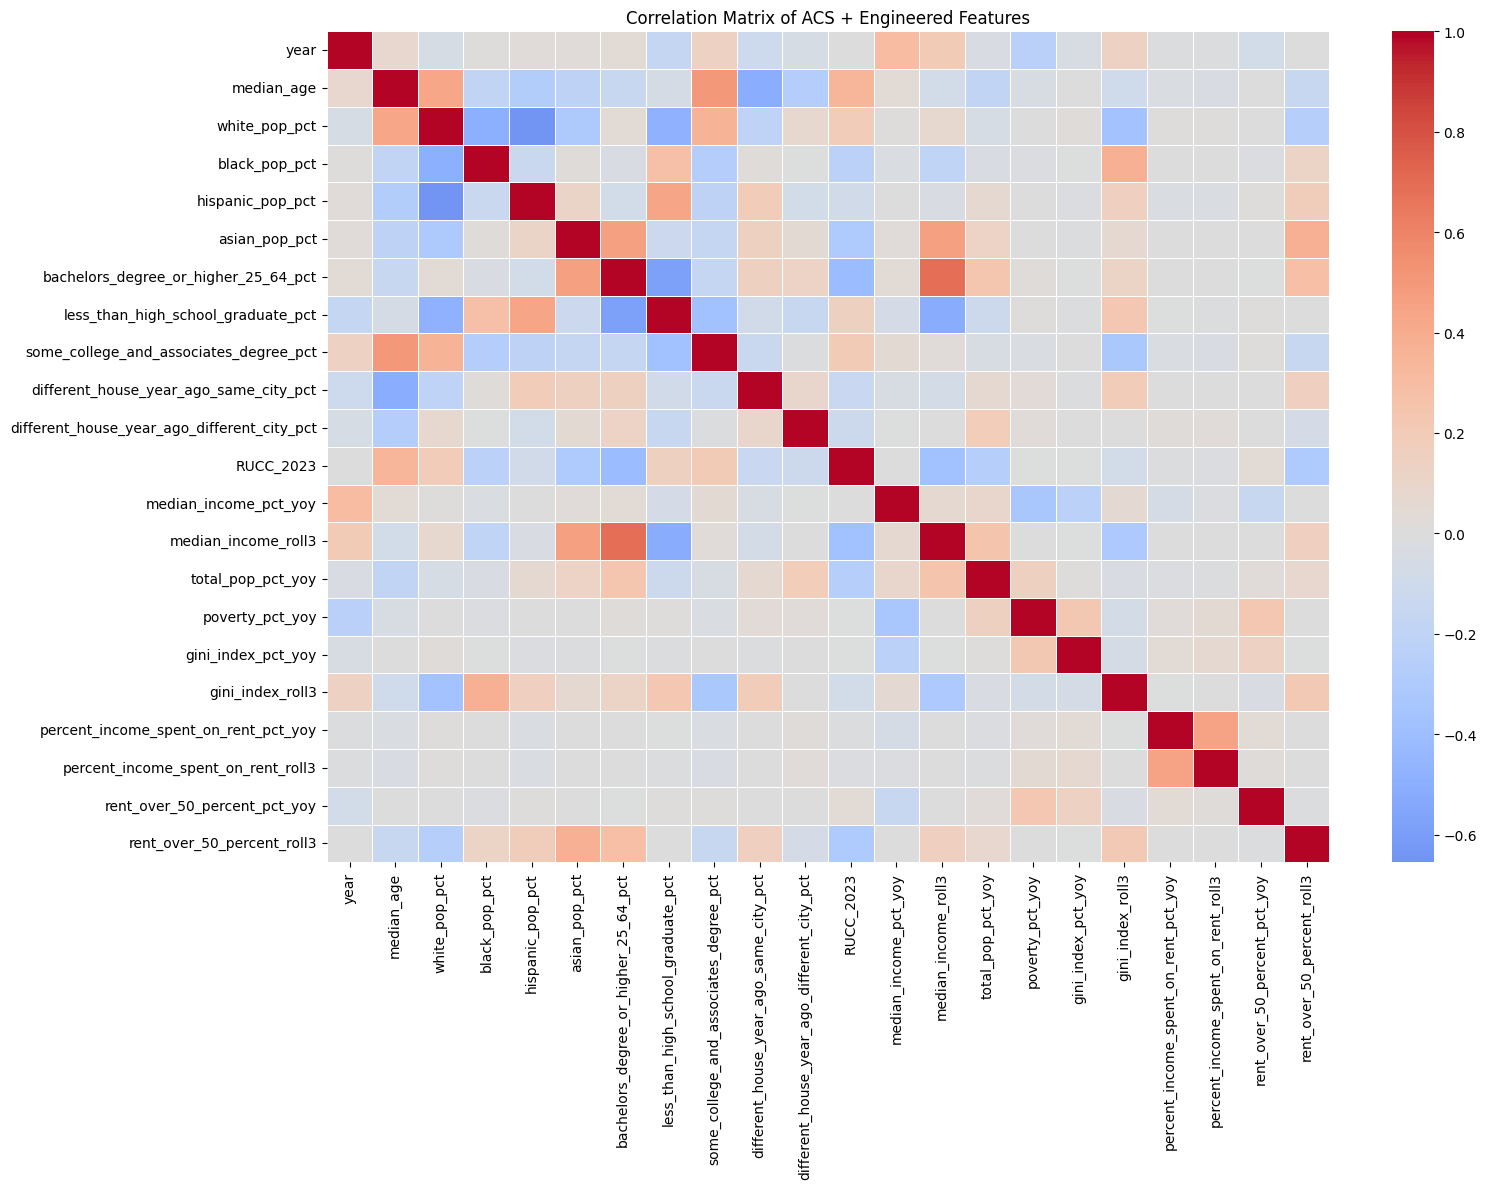

In [68]:
# Select only numeric columns (exclude object types)
numeric_cols = county_df.select_dtypes(include=["float64", "int64"]).columns

# Compute correlation matrix
corr = county_df[numeric_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Correlation Matrix of ACS + Engineered Features")
plt.tight_layout()
plt.show()

In [69]:
# Select only numeric columns for VIF calculation (exclude identifiers and categorical fields)
acs_numeric = county_df.select_dtypes(include=["float64", "int64"]).drop(columns=["year", "RUCC_2023"], errors="ignore")

# Add a constant for statsmodels VIF calculation
X = add_constant(acs_numeric)

# Compute VIF for each feature
vif_data = pd.DataFrame({
    "feature": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

# Drop the constant row for readability
vif_data = vif_data[vif_data["feature"] != "const"]

# Sort by highest VIF
vif_data = vif_data.sort_values(by="VIF", ascending=False)

print(vif_data)


                                        feature       VIF
2                                 white_pop_pct  6.509905
6          bachelors_degree_or_higher_25_64_pct  4.675683
4                              hispanic_pop_pct  4.673465
7            less_than_high_school_graduate_pct  4.171775
12                          median_income_roll3  3.511562
3                                 black_pop_pct  3.451731
1                                    median_age  2.752505
8        some_college_and_associates_degree_pct  2.457612
5                                 asian_pop_pct  1.997446
16                             gini_index_roll3  1.915744
9        different_house_year_ago_same_city_pct  1.710552
20                   rent_over_50_percent_roll3  1.296027
10  different_house_year_ago_different_city_pct  1.264445
18           percent_income_spent_on_rent_roll3  1.259072
17         percent_income_spent_on_rent_pct_yoy  1.255643
14                              poverty_pct_yoy  1.251304
11            

In [73]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the numeric columns
scaler.fit(acs_numeric)

# Transform the numeric columns
acs_numeric_scaled = scaler.transform(acs_numeric)

# Create a DataFrame with the scaled data
acs_numeric_scaled_df = pd.DataFrame(acs_numeric_scaled, columns=acs_numeric.columns)

# Merge the scaled data back with the original DataFrame
county_df_scaled = pd.concat([county_df.drop(columns=acs_numeric), acs_numeric_scaled_df], axis=1)

print(county_df_scaled.head())

  geo_id county_name  year State  \
0  01003     Baldwin  2010    AL   
1  01003     Baldwin  2011    AL   
2  01003     Baldwin  2012    AL   
3  01003     Baldwin  2013    AL   
4  01003     Baldwin  2014    AL   

                                         Description  RUCC_2023  \
0  Metro - Counties in metro areas of fewer than ...          3   
1  Metro - Counties in metro areas of fewer than ...          3   
2  Metro - Counties in metro areas of fewer than ...          3   
3  Metro - Counties in metro areas of fewer than ...          3   
4  Metro - Counties in metro areas of fewer than ...          3   

  urban_classification  median_age  white_pop_pct  black_pop_pct  ...  \
0                urban    0.234252       0.500681       0.044772  ...   
1                urban    0.307856       0.486216       0.047953  ...   
2                urban    0.271054       0.477252       0.033825  ...   
3                urban    0.326257       0.466838       0.048517  ...   
4              

c:\Users\iauge\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_factor_analysis.py:299: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  warnings.warn(


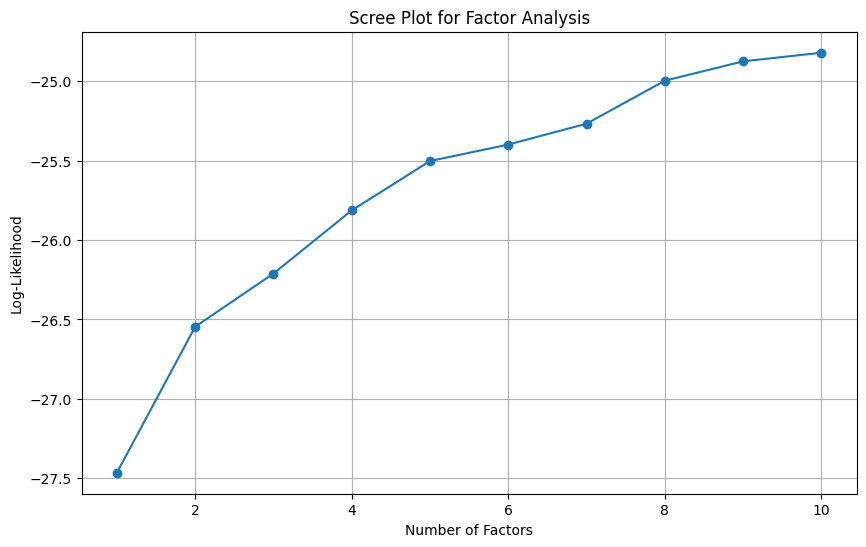

In [74]:
# Evaluate the variance explained across 1–20 factors
n_factors = list(range(1, 11))

fa_models = [FactorAnalysis(n_components=n, max_iter=1000).fit(acs_numeric_scaled) for n in n_factors]

# Extract log-likelihood values to compute approximate explained variance
log_likelihoods = [model.score(acs_numeric_scaled) for model in fa_models]

# Scree plot (based on log-likelihood gain, a proxy for information retained)
plt.figure(figsize=(10, 6))
plt.plot(n_factors, log_likelihoods, marker='o')
plt.title("Scree Plot for Factor Analysis")
plt.xlabel("Number of Factors")
plt.ylabel("Log-Likelihood")
plt.grid(True)
plt.show()

In [75]:
# Initialize and fit the factor analyzer
fa = FactorAnalyzer(n_factors=10, rotation=None)
fa.fit(acs_numeric_scaled)

# Apply varimax rotation to the factor loadings
rotator = Rotator(method="varimax")
rotated_loadings = rotator.fit_transform(fa.loadings_)

# Create a DataFrame of the rotated loadings
rotated_df = pd.DataFrame(
    rotated_loadings,
    index=acs_numeric.columns,
    columns=[f"Factor{i+1}" for i in range(rotated_loadings.shape[1])]
)

# Display top 5 features per factor based on absolute loading
for i in range(rotated_df.shape[1]):
    print(f"\nTop loadings for Factor {i+1}:")
    display(rotated_df.iloc[:, i].abs().sort_values(ascending=False).head(5))


Top loadings for Factor 1:


hispanic_pop_pct                      0.966784
white_pop_pct                         0.656993
less_than_high_school_graduate_pct    0.395084
median_age                            0.205202
rent_over_50_percent_roll3            0.132565
Name: Factor1, dtype: float64


Top loadings for Factor 2:


bachelors_degree_or_higher_25_64_pct    0.867107
median_income_roll3                     0.749327
less_than_high_school_graduate_pct      0.666465
asian_pop_pct                           0.218562
white_pop_pct                           0.162830
Name: Factor2, dtype: float64


Top loadings for Factor 3:


percent_income_spent_on_rent_roll3        0.996709
percent_income_spent_on_rent_pct_yoy      0.446560
gini_index_pct_yoy                        0.048976
some_college_and_associates_degree_pct    0.032493
total_pop_pct_yoy                         0.027527
Name: Factor3, dtype: float64


Top loadings for Factor 4:


black_pop_pct                         0.919827
white_pop_pct                         0.491480
gini_index_roll3                      0.241246
less_than_high_school_graduate_pct    0.191135
median_age                            0.172228
Name: Factor4, dtype: float64


Top loadings for Factor 5:


median_age                                     0.883545
different_house_year_ago_same_city_pct         0.565290
different_house_year_ago_different_city_pct    0.292412
less_than_high_school_graduate_pct             0.187220
some_college_and_associates_degree_pct         0.176779
Name: Factor5, dtype: float64


Top loadings for Factor 6:


poverty_pct_yoy                 0.637724
median_income_pct_yoy           0.545631
gini_index_pct_yoy              0.380272
rent_over_50_percent_pct_yoy    0.332650
gini_index_roll3                0.104053
Name: Factor6, dtype: float64


Top loadings for Factor 7:


total_pop_pct_yoy                              0.782010
different_house_year_ago_different_city_pct    0.183099
poverty_pct_yoy                                0.158957
median_income_roll3                            0.151852
median_income_pct_yoy                          0.141319
Name: Factor7, dtype: float64


Top loadings for Factor 8:


some_college_and_associates_degree_pct    0.869341
less_than_high_school_graduate_pct        0.374627
median_age                                0.338694
gini_index_roll3                          0.168960
white_pop_pct                             0.141454
Name: Factor8, dtype: float64


Top loadings for Factor 9:


gini_index_roll3                          0.649861
median_income_roll3                       0.490097
different_house_year_ago_same_city_pct    0.204028
black_pop_pct                             0.199125
bachelors_degree_or_higher_25_64_pct      0.172213
Name: Factor9, dtype: float64


Top loadings for Factor 10:


asian_pop_pct                           0.789127
rent_over_50_percent_roll3              0.441866
white_pop_pct                           0.343027
bachelors_degree_or_higher_25_64_pct    0.338303
median_income_roll3                     0.329289
Name: Factor10, dtype: float64

In [76]:
# Run Factor Analysis 
fa = FactorAnalysis(n_components=10, random_state=42)
fa.fit(acs_numeric_scaled)

# Create factor names and descriptions
factor_names = [
    "hispanic_white_composition",
    "education_income_advantage",
    "rental_cost_burden",
    "black_concentration_inequality",
    "aging_local_stability",
    "economic_volatility",
    "mid_education_profile",
    "population_growth_inflow",
    "inequality_income_duality",
    "asian_urban_profile"
]

factor_descriptions = [
    "Demographic mix of Hispanic and White populations with educational attainment",
    "High education and income, low educational disadvantage",
    "High rent-to-income burden, rental pressure",
    "Black population density and stratified inequality",
    "Older population and local residency stability",
    "Recent changes in poverty, income, and inequality",
    "Mid-education counties (some college, no degree)",
    "Migration-driven population increases",
    "Co-occurrence of wealth and income inequality",
    "High Asian population and urban housing stress"
]

# Compute factor scores
factor_scores = fa.transform(acs_numeric_scaled)
factor_score_df = pd.DataFrame(factor_scores, columns=factor_names)

# Add descriptions as metadata
factor_metadata = pd.DataFrame({
    "factor": factor_names,
    "description": factor_descriptions
})

# Merge back into your county_df_scaled (aligns by index)
county_df_with_scores = pd.concat([county_df_scaled.reset_index(drop=True), factor_score_df], axis=1)

# Optional preview
print(county_df_with_scores.head())

  geo_id county_name  year State  \
0  01003     Baldwin  2010    AL   
1  01003     Baldwin  2011    AL   
2  01003     Baldwin  2012    AL   
3  01003     Baldwin  2013    AL   
4  01003     Baldwin  2014    AL   

                                         Description  RUCC_2023  \
0  Metro - Counties in metro areas of fewer than ...          3   
1  Metro - Counties in metro areas of fewer than ...          3   
2  Metro - Counties in metro areas of fewer than ...          3   
3  Metro - Counties in metro areas of fewer than ...          3   
4  Metro - Counties in metro areas of fewer than ...          3   

  urban_classification  median_age  white_pop_pct  black_pop_pct  ...  \
0                urban    0.234252       0.500681       0.044772  ...   
1                urban    0.307856       0.486216       0.047953  ...   
2                urban    0.271054       0.477252       0.033825  ...   
3                urban    0.326257       0.466838       0.048517  ...   
4              

c:\Users\iauge\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_factor_analysis.py:299: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  warnings.warn(


Silhouette Score for 2 clusters: 0.14343882775862177
Inertia for 2 clusters: 139483.0728899274
Silhouette Score for 3 clusters: 0.15604850706586673
Inertia for 3 clusters: 128482.71441015787
Silhouette Score for 4 clusters: 0.16412801390469084
Inertia for 4 clusters: 119205.43117265927
Silhouette Score for 5 clusters: 0.16575795505818522
Inertia for 5 clusters: 106587.32386655426
Silhouette Score for 6 clusters: 0.15902204529982694
Inertia for 6 clusters: 100523.9656669765
Silhouette Score for 7 clusters: 0.1530201619339936
Inertia for 7 clusters: 89665.51292373246
Silhouette Score for 8 clusters: 0.14268786358016436
Inertia for 8 clusters: 84067.67168237986
Silhouette Score for 9 clusters: 0.14475336284682358
Inertia for 9 clusters: 79590.45084024723
Silhouette Score for 10 clusters: 0.14159234907731436
Inertia for 10 clusters: 76325.43370948228


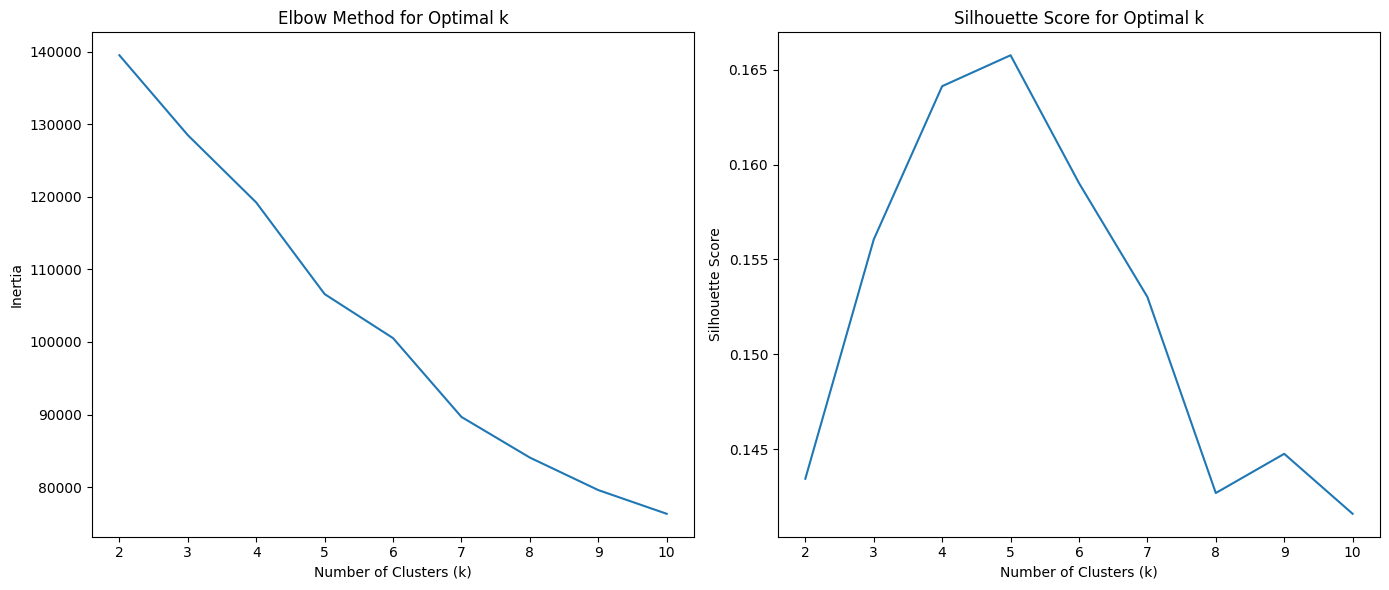

In [ ]:
county_df_with_scores["geo_id"] = county_df_with_scores["geo_id"].astype(str)
county_df["geo_id"] = county_df["geo_id"].astype(str)

# Merge RUCC_2023 from the original dataframe
county_df_with_scores = county_df_with_scores.merge(
    county_df[["geo_id", "year", "RUCC_2023"]],
    on=["geo_id", "year"],
    how="left"
)

county_df_with_scores["RUCC_2023_scaled"] = scaler.fit_transform(
    county_df_with_scores[["RUCC_2023"]]
)
# Drop the original RUCC_2023 column
county_df_with_scores.drop(columns=["RUCC_2023"], inplace=True)

cluster_cols = factor_names + ["RUCC_2023_scaled"]
cluster_df = county_df_with_scores[cluster_cols].copy()

X = cluster_df[cluster_cols]

inertia = []
silhouette_scores = []
range_n_clusters = range(2, 11)
for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(X)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, labels))
    print(f"Silhouette Score for {k} clusters: {silhouette_scores[-1]}")
    print(f"Inertia for {k} clusters: {inertia[-1]}")

# Plot the elbow method
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
sns.lineplot(x=range_n_clusters, y=inertia, ax=axs[0])
axs[0].set_title("Elbow Method for Optimal k")
axs[0].set_xlabel("Number of Clusters (k)")
axs[0].set_ylabel("Inertia")

sns.lineplot(x=range_n_clusters, y=silhouette_scores, ax=axs[1])
axs[1].set_title("Silhouette Score for Optimal k")
axs[1].set_xlabel("Number of Clusters (k)")
axs[1].set_ylabel("Silhouette Score")

plt.tight_layout()
plt.show()    

In [97]:
# Assign cluster labels to the DataFrame
optimal_k = 4  # Based on elbow method and silhouette score

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init="auto")
county_df_with_scores["cluster"] = kmeans.fit_predict(county_df_with_scores[cluster_cols])

print(county_df_with_scores["cluster"].value_counts())

cluster
1    6838
0    6745
3    1980
2    1297
Name: count, dtype: int64


In [100]:
# Merge cluster labels back to the original DataFrame
labeled_county_df = county_df.merge(
    county_df_with_scores[["geo_id", "year"] + factor_names + ["cluster"]],
    on=["geo_id", "year"],
    how="left"
)


In [106]:
cluster_summary = labeled_county_df.groupby("cluster")[[
    "hispanic_white_composition", "education_income_advantage", "rental_cost_burden",
    "black_concentration_inequality", "aging_local_stability", "economic_volatility",
    "mid_education_profile", "population_growth_inflow", "inequality_income_duality",
    "asian_urban_profile", "RUCC_2023"
]].mean().round(2)

print(cluster_summary)


         hispanic_white_composition  education_income_advantage  \
cluster                                                           
0                              0.28                        0.68   
1                             -0.65                       -0.26   
2                              1.94                       -1.86   
3                             -0.00                       -0.19   

         rental_cost_burden  black_concentration_inequality  \
cluster                                                       
0                      0.07                           -0.18   
1                      0.01                            0.08   
2                      1.06                           -0.28   
3                     -0.96                            0.54   

         aging_local_stability  economic_volatility  mid_education_profile  \
cluster                                                                      
0                        -0.14                 0.03           

In [110]:
cluster_names = {
    0: "Urban Professional Core",
    1: "Rural Working Class",
    2: "Latino Urban Disadvantage",
    3: "Aging Rural Counties"
}
labeled_county_df["cluster_label"] = labeled_county_df["cluster"].map(cluster_names)

# Reorder columns for clarity
ordered_columns = [
    # Identifiers & cluster labels
    "geo_id", "county_name", "State", "year", "RUCC_2023", "urban_classification", "Description",
    "cluster", "cluster_label",

    # Raw ACS features
    "median_age", "white_pop_pct", "black_pop_pct", "hispanic_pop_pct", "asian_pop_pct",
    "bachelors_degree_or_higher_25_64_pct", "less_than_high_school_graduate_pct",
    "some_college_and_associates_degree_pct", "different_house_year_ago_same_city_pct",
    "different_house_year_ago_different_city_pct", "median_income_pct_yoy", "median_income_roll3",
    "total_pop_pct_yoy", "poverty_pct_yoy", "gini_index_pct_yoy", "gini_index_roll3",
    "percent_income_spent_on_rent_pct_yoy", "percent_income_spent_on_rent_roll3",
    "rent_over_50_percent_pct_yoy", "rent_over_50_percent_roll3",

    # Factor scores
    "hispanic_white_composition", "education_income_advantage", "rental_cost_burden",
    "black_concentration_inequality", "aging_local_stability", "economic_volatility",
    "mid_education_profile", "population_growth_inflow", "inequality_income_duality",
    "asian_urban_profile"
]

# Apply the reordering
labeled_county_df = labeled_county_df[ordered_columns]

labeled_county_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 39 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   geo_id                                       16860 non-null  object 
 1   county_name                                  16860 non-null  object 
 2   State                                        16860 non-null  object 
 3   year                                         16860 non-null  int64  
 4   RUCC_2023                                    16860 non-null  int64  
 5   urban_classification                         16860 non-null  object 
 6   Description                                  16860 non-null  object 
 7   cluster                                      16860 non-null  int32  
 8   cluster_label                                16860 non-null  object 
 9   median_age                                   16860 non-null  float64
 10

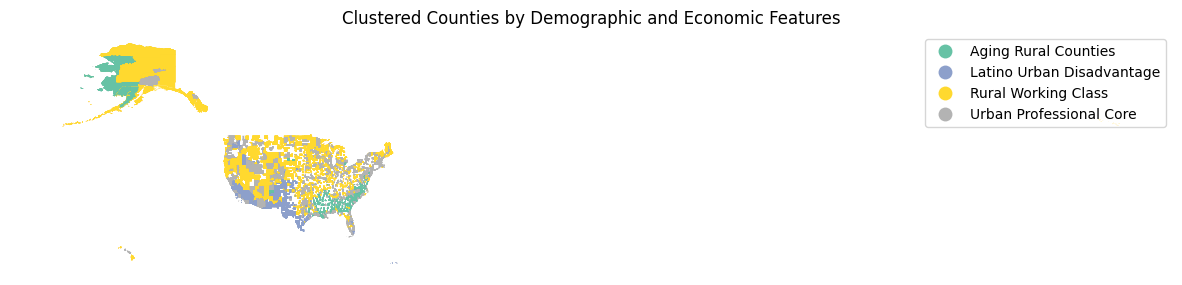

In [113]:
county_dtypes = {
    "geo_id": str,
    "state": str,
    "county_name": str,
    "urban_classification": str
}

county_df = pd.read_csv(DATA_DIR / "county_weather_acs_training.csv", dtype=county_dtypes)

# Re-add polygon geometry
labeled_county_df = labeled_county_df.merge(
    county_df[["geo_id", "year", "county_geometry"]],
    on=["geo_id", "year"],
    how="left"
)

gdf = gpd.GeoDataFrame(
    labeled_county_df,
    geometry=gpd.GeoSeries.from_wkt(labeled_county_df["county_geometry"]),
    crs="EPSG:4326"
)   

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
gdf.plot(column="cluster_label", cmap="Set2", legend=True, ax=ax)
ax.set_title("Clustered Counties by Demographic and Economic Features")
ax.set_axis_off()
plt.show()